In [1]:
%pylab inline
from pyspark import SparkContext, SparkConf
from pyspark.mllib.linalg.distributed import IndexedRow, IndexedRowMatrix
np.set_printoptions(precision=3, suppress=True)
import numpy as np
import os
import time

# Custom functions for the task.
from VAT import VAT
from iVAT import iVAT
from dissimilarity import dissimilarity
from sVatSampling import sVatSampling

start_time = time.time()

Populating the interactive namespace from numpy and matplotlib


In [2]:
# INPUTS TO ALGORITHM
setSelector = 20 # This number selects a UCR time series. 76 is a big one.
clustEst = 10            # Initial guess of number of clusters.
sampleRatio = 0.1
# Can select 'euclidian', 'NCC', or 'DTW' as distance metric.
metric = 'NCC'

# If checking algorithmic performance all additional printing, figure display
# options will be removed.
test_run = True
optimised = True
save_pics = True

# Data input - assumes this is done externally - not considered part of complexity.
datapath = 'UCR_TS_Archive_2015/'
datadirlist = os.listdir(datapath)
datadirlist.sort()
datadir = datapath+datadirlist[setSelector]+'/'
datafile = [i for i in os.listdir(datadir) if 'TEST' in i]
f = file(datadir+datafile[0])

for i in range(len(datadirlist)):
    print i, datadirlist[i]

0 50words
1 Adiac
2 ArrowHead
3 Beef
4 BeetleFly
5 BirdChicken
6 CBF
7 Car
8 ChlorineConcentration
9 CinC_ECG_torso
10 Coffee
11 Computers
12 Cricket_X
13 Cricket_Y
14 Cricket_Z
15 DiatomSizeReduction
16 DistalPhalanxOutlineAgeGroup
17 DistalPhalanxOutlineCorrect
18 DistalPhalanxTW
19 ECG200
20 ECG5000
21 ECGFiveDays
22 Earthquakes
23 ElectricDevices
24 FISH
25 FaceAll
26 FaceFour
27 FacesUCR
28 FordA
29 FordB
30 Gun_Point
31 Ham
32 HandOutlines
33 Haptics
34 Herring
35 InlineSkate
36 InsectWingbeatSound
37 ItalyPowerDemand
38 LargeKitchenAppliances
39 Lighting2
40 Lighting7
41 MALLAT
42 Meat
43 MedicalImages
44 MiddlePhalanxOutlineAgeGroup
45 MiddlePhalanxOutlineCorrect
46 MiddlePhalanxTW
47 MoteStrain
48 NonInvasiveFatalECG_Thorax1
49 NonInvasiveFatalECG_Thorax2
50 OSULeaf
51 OliveOil
52 PhalangesOutlinesCorrect
53 Phoneme
54 Plane
55 ProximalPhalanxOutlineAgeGroup
56 ProximalPhalanxOutlineCorrect
57 ProximalPhalanxTW
58 RefrigerationDevices
59 ScreenType
60 ShapeletSim
61 ShapesAll


In [3]:
# Array of time series data. This is a poor way of doing it because it means the series must be 
# strorable in memory before being converted to a RDD.
ts = np.genfromtxt(f, delimiter = ',')
numSeries = len(ts)
lenSeries = len(ts[0,1:])
lenSeriesPow2 = np.power(2,int(np.ceil(np.log2(lenSeries))))
timeSeries = [i for i in range(numSeries)]
for i in range(numSeries):
    timeSeries[i] = i, np.append(ts[i,1:], np.zeros(lenSeriesPow2-lenSeries))
    
# Indicates initial setup has been performed and data loaded from file.
preprocessing_time = time.time()

In [4]:
# Partitioning component.

# This is actually not the preferred way of distributing data - as we have actually sent this data across all 
# nodes and are just waiting for it to be acted on - in practise this is wasteful.
if optimised:
    timeSeriesRDD = sc.parallelize(timeSeries,numSlices=3)
else:
    timeSeriesRDD = sc.parallelize(timeSeries)

In [5]:
if sampleRatio != 1.0:
    sampledRow, sampleIndex, protoClust = sVatSampling(
        timeSeriesRDD, numSeries, metric=metric, clustEst = clustEst, sampleRatio = sampleRatio)
    sampleSize = len(sampleIndex)
else:
    sampledRow = timeSeriesRDD
    sampleSize = numSeries

sample_time = time.time()

sVatSampling.py:42: ComplexWarning: Casting complex values to real discards the imaginary part
  init_row[i[0]] = i[1]
sVatSampling.py:87: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  sampleIndex =  np.append(sampleIndex, np.random.choice(m_ind[0],m_cnt,replace=False))


In [6]:
# Create RDD consisting of indexed dissimilarity arrays of each time series.
# Can select 'euclidian', 'NCC', or 'DTW' as distance metric.
tsDissimRDD = dissimilarity(sampledRow,numSeries=sampleSize,metric=metric)

In [7]:
tsDissimSampled = tsDissimRDD.collect()

dissim_mat_time = time.time()

tsDissimSampled.sort(key = lambda tup: tup[0])

tsDissimMatrixSampled = np.vstack(tuple(i[1] for i in tsDissimSampled))

end_time = time.time()

In [8]:
D_iVAT, D_VAT, I_VAT, C, d = iVAT(tsDissimMatrixSampled)

## RESULTS

In [9]:
iVAT_develop = time.time()

pre_time = preprocessing_time - start_time
produce_sample = sample_time - preprocessing_time
build_dissim_mat = dissim_mat_time - sample_time
vattime = iVAT_develop - sample_time
totalruntime = iVAT_develop - start_time

print("Pre-processing time = %s seconds" % pre_time)
print("Sampled time series data = %s seconds" % produce_sample)
print("Build sampled dissimilarity matrix =  %s seconds" % build_dissim_mat)
print("iVAT developement time =  %s seconds" % vattime)
print("Total runtime =  %s seconds" % totalruntime)

print([setSelector,clustEst,sampleRatio,produce_sample,build_dissim_mat,vattime])

Pre-processing time = 1.88088297844 seconds
Sampled time series data = 17.0776400566 seconds
Build sampled dissimilarity matrix =  4.83047604561 seconds
iVAT developement time =  5.2174179554 seconds
Total runtime =  24.1759409904 seconds
[20, 10, 0.1, 17.077640056610107, 4.8304760456085205, 5.21741795539856]


There are 4500 series and 140 samples per series in the 'ECG5000' dataset.


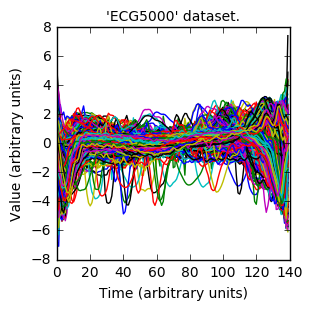

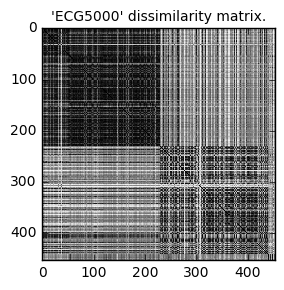

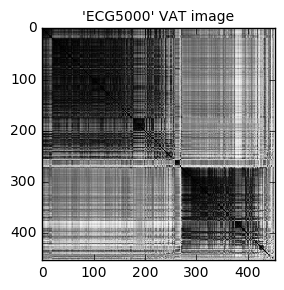

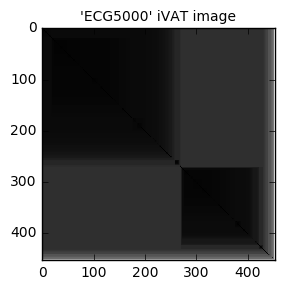

In [10]:
print('There are '+str(numSeries)+' series and '+str(lenSeries)+
      ' samples per series in the \''+datadirlist[setSelector]+'\' dataset.')

fig = figure(figsize=(3,3))
plt.plot(ts[:,1:].T);
plt.xlabel('Time (arbitrary units)')
plt.ylabel('Value (arbitrary units)')
plt.title('\''+datadirlist[setSelector]+'\' dataset.',fontsize='medium')

fig = figure(figsize=(3,3))
plt.imshow(tsDissimMatrixSampled,cmap='Greys_r',interpolation='none');
plt.title('\''+datadirlist[setSelector]+'\' dissimilarity matrix.',fontsize='medium')

if save_pics: fig.savefig('./images/dismat_'
            +str(datadirlist[setSelector])+str(metric)+str(sampleRatio)+'.pdf'
            ,type='pdf',bbox_inches='tight')

fig = figure(figsize=(3,3))
plt.imshow(D_VAT,cmap='Greys_r',interpolation='none');
plt.title('\''+datadirlist[setSelector]+'\' VAT image',fontsize='medium')

if save_pics: fig.savefig('./images/VAT_'
            +str(datadirlist[setSelector])+str(metric)+str(sampleRatio)+'.pdf'
            ,type='pdf',bbox_inches='tight')

fig = figure(figsize=(3,3))
plt.imshow(D_iVAT,cmap='Greys_r',interpolation='none');
plt.title('\''+datadirlist[setSelector]+'\' iVAT image',fontsize='medium')

if save_pics: fig.savefig('./images/iVAT_'
            +str(datadirlist[setSelector])+str(metric)+str(sampleRatio)+'.pdf'
            ,type='pdf',bbox_inches='tight')

In [13]:
clusiVATcheck = False

import pickle

f_iVAT = open('Results/'+datadirlist[setSelector]+'_'+metric+'_iVAT.csv','wb')
numpy.savetxt(f_iVAT,D_iVAT,delimiter=',')
f_iVAT.close()
fl_iVAT = open('Results/latest_VAT.csv','w')
numpy.savetxt(fl_iVAT,D_iVAT,delimiter=',')
fl_iVAT.close()

f_VAT = open('Results/'+datadirlist[setSelector]+'_'+metric+'_VAT.csv','wb')
numpy.savetxt(f_VAT,D_VAT,delimiter=',')
f_VAT.close()
fl_VAT = open('Results/latest_iVAT.csv','wb')
numpy.savetxt(fl_VAT,D_VAT,delimiter=',')
fl_VAT.close()

if clusiVATcheck and sampleRatio != 1.0:
    fl_disful = open('Results/latest_disful.csv','wb')
    numpy.savetxt(fl_disful,tsDissimMatrixFull,delimiter=',')
    fl_disful.close()

f_ind = open('Results/'+datadirlist[setSelector]+'_'+metric+'_ind.pickle','wb')
fl_ind = open('Results/latest_ind.pickle','wb')
pickle.dump(I_VAT,f_ind)
pickle.dump(I_VAT,fl_ind)
f_ind.close()
fl_ind.close()

f_sind = open('Results/'+datadirlist[setSelector]+'_'+metric+'_sind.pickle','wb')
fl_sind = open('Results/latest_sind.pickle','wb')
pickle.dump(sampleIndex,f_sind)
pickle.dump(sampleIndex,fl_sind)
f_sind.close()
fl_sind.close()

f_MSTC = open('Results/'+datadirlist[setSelector]+'_'+metric+'_MSTC.pickle','wb')
fl_MSTC = open('Results/latest_MSTC.pickle','wb')
pickle.dump(C,f_MSTC)
pickle.dump(C,fl_MSTC)
f_MSTC.close()
fl_MSTC.close()

f_MSTd = open('Results/'+datadirlist[setSelector]+'_'+metric+'_MSTd.pickle','wb')
fl_MSTd = open('Results/latest_MSTd.pickle','wb')
pickle.dump(d,f_MSTd)
pickle.dump(d,fl_MSTd)
f_MSTd.close()
fl_MSTd.close()

f_meta = open('Results/'+datadirlist[setSelector]+'_meta.pickle','wb')
fl_meta = open('Results/latest_meta.pickle','wb')
pickle.dump({'set': setSelector, 'sample ratio': sampleRatio, 'metric': metric},f_meta)
pickle.dump({'set': setSelector, 'sample ratio': sampleRatio, 'metric': metric},fl_meta)
f_meta.close()
fl_meta.close()